## 次元削減でデータを圧縮する
特徴選択に代わる次元削減のもう1つの方法は**特徴抽出(feature extraction)**である。
この章では、以下の3つの特徴選択の方法について取り上げる

- 教師なしデータ圧縮での**主成分分析(PCA)**
- クラスの分離を最大化する教師あり次元削減法としての**線形判別分析(LDA)**
- **カーネル主成分分析(KPCA)**による非線形次元削減

## 5.1 主成分分析による教師なし次元削減
**主成分分析(principal Component Analysis:PCA)**はよく特徴抽出と次元削減に使用されている。

PCAは特徴量どうしの相関関係に基づいてデータからパターンを抽出するのに役に立つ。

## 5.1 主成分を抽出する
PCAの最初の4つの手順に取り組む
1. データを標準化する
1. 共分散行列を作成する
1. 共分散行列の固有値と固有ベクトルを取得する
1. 固有値を降順でソートすることで、固有ベクトルをランク付けする

In [1]:
import pandas as pd
df_wine = pd.read_csv(
'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)

In [2]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

# 2列目以降のデータをXに、1列目のデータをyに変換
X,y = df_wine.iloc[:,1:].values,df_wine.iloc[:,0].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,
                                                stratify=y,random_state=0)

# 平均と標準偏差を用いて標準化
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

C:\Users\zundo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import numpy as np

# 共分散行列を作成
cov_mat = np.cov(X_train_std.T)
# 固有値と固有ベクトルを計算
eigen_vals,eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


In [4]:
# 固有値の合計
tot = sum(eigen_vals)
# 分散説明率を計算
var_exp = [(i / tot) for i in sorted(eigen_vals,reverse=True)]
# 分散説明率の累計和を取得
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
# 分散説明率の棒グラフを作成
plt.bar(range(1,14),var_exp,alpha=0.5,align='center',
       label='individual expained variance')
# 分散説明率の累計和の階段グラフを作成
plt.step(range(1,14),cum_var_exp,where='mid',label='cumlative explained variance')
plt.ylabel('Explained variance ratic')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

PCAは、クラスラベルに関する情報は使用していない。またPCAで計算される分散は**特徴軸に沿った値の散らばり**を測定する。

## 5.1 特徴変換
PCAの残りの3つの手順を行う。
- 最も大きいk個の固有値に対するk個の固有ベクトルを選択する。この場合のkは新しい特徴部分空間の次元数を表す(k≤d)
- 上位k個の固有ベクトルから射影行列Wを作成する
- 射影行列Wを使用し、d次元の入力データセットXを変換し、新しいk次元の特徴部分空間を選択する

In [5]:
# (固有値、固有ベクトル）のタプルのリストを作成する
eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i])
              for i in range(len(eigen_vals))]

# (固有値、固有ベクトル)のタプルを大きいものから順に並び変え
eigen_pairs.sort(key=lambda k: k[0],reverse=True)

In [6]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis],eigen_pairs[1][1][:,np.newaxis]))
print('Marrix W\n',w)

Marrix W
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [7]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [8]:
X_train_pca = X_train_std.dot(w)

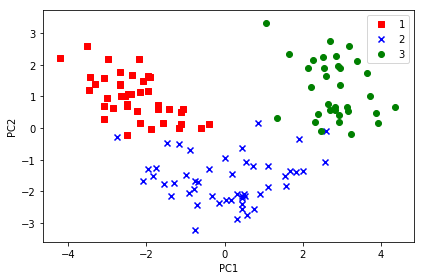

In [9]:
colors = ['r','b','g']
markers = ['s','x','o']

# 「クラスラベル」「点の色」「点の種類」の組み合わせからなるリストを生成してプロット
for l,c,m in zip(np.unique(y_train),colors,markers):
    plt.scatter(X_train_pca[y_train==l,0],X_train_pca[y_train==l,1],
               c=c,label=l,marker=m)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

説明分散の通りPC1のほうがX軸沿いに広がっている。この散布図ではクラスラベルを使用したが、PCAがクラスラベルの情報を使用しない教師なしデータ圧縮法であることに注意しなければならない。

## 5.1 scikit-learnの主成分分析

In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X,y,classifiier,resolution=0.02):
    # マーカーとカラーマップの準備
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min,x1_max = X[:,0].min()-1,X[:,0].max()+1
    x2_min,x2_max = X[:,1].min()-1,X[:,1].max()+1
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                         np.arange(x2_min,x2_max,resolution))
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifiier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1,xx2,Z,alpha=0.4,cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    # クラス毎にサンプルをプロット
    for idx,cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0],
                   y=X[y==cl,1],
                   alpha=0.6,
                   c=cmap(idx),
                   edgecolor='black',
                   marker=markers[idx],
                   label=cl)

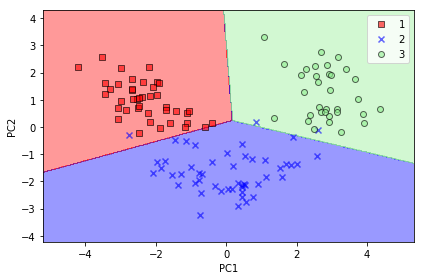

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# 主成分数を指定して、PCAのインスタンスを生成
pca = PCA(n_components=2)
# ロジスティクス回帰のインスタンスを生成
lr = LogisticRegression()
# トレーニングデータとテストデータでPCAを実行
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# トレニンーグデータでロジスティクス回帰を実行
lr.fit(X_train_pca,y_train)

# 決定境界をプロット
plot_decision_regions(X_train_pca,y_train,classifiier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

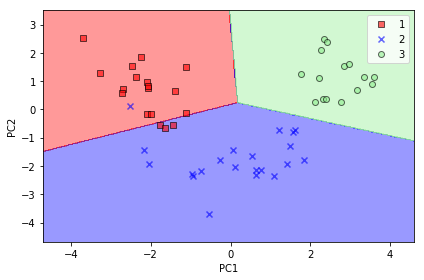

In [12]:
plot_decision_regions(X_test_pca,y_test,classifiier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

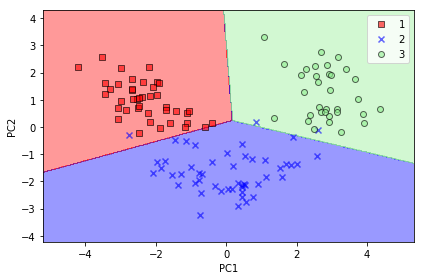

In [13]:
X_train_std1,X_test_std1 = X_train_std * -1,X_test_std*-1
# トレーニングデータとテストデータでPCAを実行
X_train_pca = pca.fit_transform(X_train_std1)
X_test_pca = pca.transform(X_test_std1)

# トレニンーグデータでロジスティクス回帰を実行
lr.fit(X_train_pca,y_train)

# 決定境界をプロット
plot_decision_regions(X_train_pca,y_train,classifiier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [14]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
# 分散説明率を計算
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

## 5.2 線形判別分析による教師ありデータ圧縮
**線形判別分析(Linear Discriminant Analysis:LDA)**は計算効率を高め、正規化されていいないモデルの「次元の呪い」による過学習を抑制するために使用できる。

LDAはクラスの分離を最適化する特徴部分空間を見つけ出そうとする。LDAを実行するために必要な手順は以下の通りである。
1. d次元のデータセットを標準化する(dは特徴量の個数)
1. クラスごとにd次元の平均ベクトル(各次元の平均値で構成されるベクトル)を計算する
1. 平均ベクトルを使ってクラス間変動行列$S_B$とクラス内変動行列$S_W$を生成する
1. 行列$S^{-1}_W S_B$の固有ベクトルと対応する固有値を計算する
1. 固有値を降順でソートすることで、対応する固有ベクトルをランク付けする
1. d*k次元の変換行列Wを生成するために、最も大きいk個の固有値に対応するk個の固有ベクトルを選択する(固有ベクトルから変換行列Wを生成)。固有ベクトルは、この行列の列である
1. 変換行列Wを使ってサンプルを新しい特徴部分空間へ射影する。

In [15]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label],axis=0))
    print('NV %s:%s\n' % (label,mean_vecs[label-1]))

NV 1:[ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

NV 2:[-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

NV 3:[ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [16]:
d = 13 # 特徴量の個数
S_W = np.zeros((d,d))
for label,mv in zip(range(1,4),mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_train_std[y_train == label]:
        row,mv = row.reshape(d,1),mv.reshape(d,1)
        class_scatter += (row -mv).dot((row-mv).T)
    S_W += class_scatter
    
print('Within-class scatter matrix: %s x %s' % (S_W.shape[0],S_W.shape[1]))

Within-class scatter matrix: 13 x 13


変動行列を計算するときには、トレニンーグデータセットにおいてクラスラベルが一様に分布していることが前提となる。だが、クラスラベルの個数を出力するとこの前提を満たしていないことがわかる。

In [17]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


そのため個々の変動行列$S_i$を合計して変動行列$S_w$を生成する前に、スケーリングが必要である。

In [18]:
d = 13
S_W = np.zeros((d,d))
for label,mv in zip(range(1,4),mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
    
print('Scaled within-class scatter matrix:%s x %s' % (S_W.shape[0],S_W.shape[1]))

Scaled within-class scatter matrix:13 x 13


In [19]:
mean_ovarall = np.mean(X_train_std,axis=0)
d = 13
S_B = np.zeros((d,d))
for i ,mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i+1,:].shape[0]
    # 列ベクトルを作成
    mean_vec = mean_vec.reshape(d,1)
    mean_ovarall = mean_ovarall.reshape(d,1)
    S_B += n*(mean_vec - mean_ovarall).dot((mean_vec - mean_ovarall).T)
print('Between - class scatter matrix: %sx%s' % (S_B.shape[0],S_B.shape[1]))

Between - class scatter matrix: 13x13


## 5.2 新しい特徴部分空間の線形判別を選択する
LDAの残りの手順は、PCAの手順と似ている。ただし、共分散行列で固有分解を実行するのではなく、行列$S^{-1}_W S_B$の一般化された固有値問題を解く。

In [20]:
# inv関数で逆行列、dot関数で行列積、eig関数で固有値を計算
eigen_vals,eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [21]:
eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i])
              for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,key=lambda k :k[0],reverse=True)
print('Eigenvals in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvals in descending order:

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


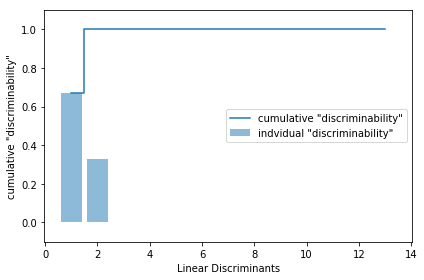

In [22]:
# 固有値の実数部の総和を求める
tot = sum(eigen_vals.real)
# 分散説明率とその累計和を計算
discr = [(i / tot) for i in sorted(eigen_vals.real,reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1,14),discr,alpha=0.5,align='center',
       label='indvidual "discriminability"')
plt.step(range(1,14),cum_discr,where='mid',
        label='cumulative "discriminability"')
plt.ylabel('cumulative "discriminability"')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1,1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [23]:
# 2つの固有ベクトルから変換行列を作成
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real,
              eigen_pairs[1][1][:,np.newaxis].real))
print('Matrix W:\n',w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


## 5.2 新しい特徴空間にサンプルを射影する
### $X'=XW$

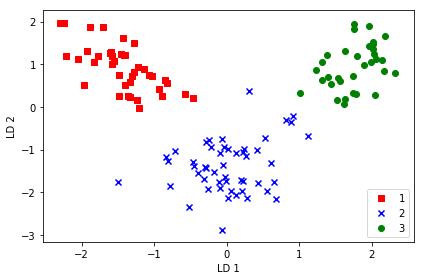

In [24]:
# 標準化したトレーニングデータに変換行列を掛ける
X_train_lda = X_train_std.dot(w)
colors = ['r','b','g']
markers = ['s','x','o']
for l,c,m in zip(np.unique(y_train),colors,markers):
    plt.scatter(X_train_lda[y_train == l,0],
               X_train_lda[y_train==l,1]*(-1),
               c=c,label=l,marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## scikit-learnによる線形判別分析

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# 次元数を設定して、LDAのインスタンスを生成
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std,y_train)

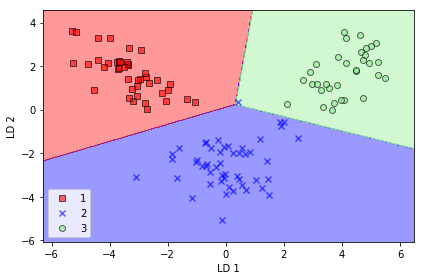

In [26]:
lr = LogisticRegression()
lr = lr.fit(X_train_lda,y_train)
plot_decision_regions(X_train_lda,y_train,classifiier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

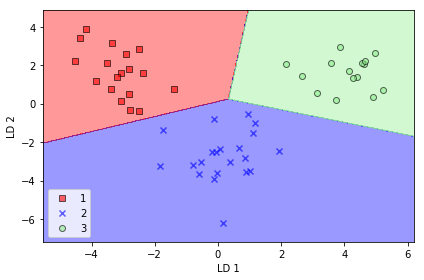

In [27]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda,y_test,classifiier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 5.3 カーネル主成分分析を使った非線形写像
**カーネルPCA(KPCA)**を使用して、線形に分離できないデータを変換し、線形分類器に適した新しい低次元の部分空間へ射影する方法を学ぶ。
簡単に説明するとデータをより高い次元へと射影したあとに、PCAを使用して線形分類器で分離できるようにする手法。

In [28]:
from scipy.spatial.distance import pdist,squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X,gamma,n_components):
    
    """RBFカーネルPCAの実装
    
    パラメータ
    ----------------------
    X:(Numpy ndarray),shape=[n_samples,n_features]
    
    gamma:float
        RBFカーネルのチューニングパラメータ
        
    n_components:int
        返される主成分の個数
        
    戻り値
    ----------------------
    X_pca:(Numpy ndarray),shape=[n_samples,k_features]
        射影されたデータセット
        
    """
    
    #  M*N次元のデータセットでペアごとのユークリッド距離の2乗を計算
    sq_dists = pdist(X,'sqeuclidean')
    # ペアごとの距離を正方行列に変換
    mat_sq_dists = squareform(sq_dists)
    
    # 対称カーネル行列を計算
    K = exp(-gamma * mat_sq_dists)
    
    # カーネル行列を中心化
    N = K.shape[0]
    one_n = np.ones((N,N))/N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # 中心化されたカーネル行列から固有対を取得
    # scipy.linlg.eighはそれらを昇順で返す
    eigvals,eigvecs = eigh(K)
    eigvals,eigvecs = eigvals[::-1],eigvecs[:,::-1]
    
    # 上位k個の固有ベクトル（射影されたサンプル）を収集
    X_pc = np.column_stack((eigvecs[:,i]
                           for i in range(n_components)))
    
    return X_pc

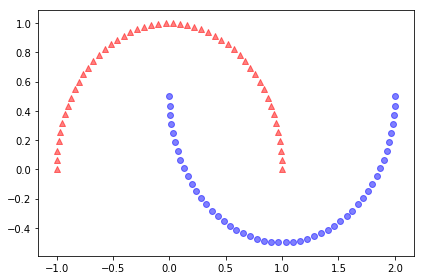

In [29]:
# 2つの半月形データを作成してプロット
from sklearn.datasets import make_moons
X,y = make_moons(n_samples=100,random_state=123)
plt.scatter(X[y==0,0],X[y==0,1],color='red',marker='^',alpha=0.5)
plt.scatter(X[y==1,0],X[y==1,1],color='blue',marker='o',alpha=0.5)
plt.tight_layout()
plt.show()

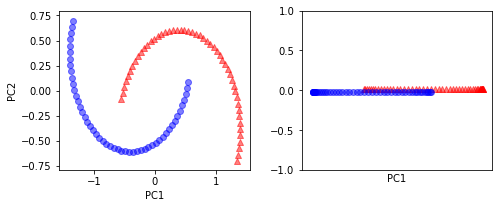

In [30]:
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
# グラフの数と配置、サイズを指定
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(7,3))
# 1番目のグラフ領域に散布図をプロット
ax[0].scatter(X_spca[y==0,0],X_spca[y==0,1],color='red',marker='^',alpha=0.5)
ax[0].scatter(X_spca[y==1,0],X_spca[y==1,1],color='blue',marker='o',alpha=0.5)

# 2番目のグラフ領域に散布図をプロット
ax[1].scatter(X_spca[y==0,0],np.zeros((50,1))+0.02,color='red',marker='^',alpha=0.5)
ax[1].scatter(X_spca[y==1,0],np.zeros((50,1))-0.02,color='blue',marker='o',alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_xticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

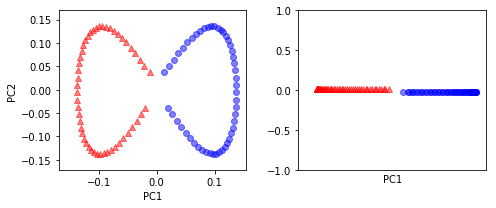

In [31]:
from matplotlib.ticker import FormatStrFormatter
# カーネルPCA関数を実行(データ、チューニング、パラメータ、次元数を指定）
X_pca = rbf_kernel_pca(X,gamma=15,n_components=2)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(7,3))
ax[0].scatter(X_pca[y==0,0],X_pca[y==0,1],
             color='red',marker='^',alpha=0.5)
ax[0].scatter(X_pca[y==1,0],X_pca[y==1,1],
             color='blue',marker='o',alpha=0.5)

ax[1].scatter(X_pca[y==0,0],np.zeros((50,1))+0.02,
             color='red',marker='^',alpha=0.5)
ax[1].scatter(X_pca[y==1,0],np.zeros((50,1))-0.02,
             color='blue',marker='o',alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_xticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

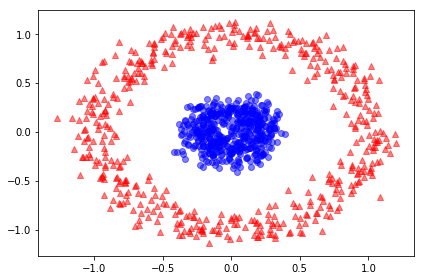

In [32]:
# 同心円の分離
from sklearn.datasets import make_circles
X,y = make_circles(n_samples=1000,random_state=123,noise=0.1,factor=0.2)
plt.scatter(X[y==0,0],X[y==0,1],color='red',marker='^',alpha=0.5)
plt.scatter(X[y==1,0],X[y==1,1],color='blue',marker='o',alpha=0.5)
plt.tight_layout()
plt.show()

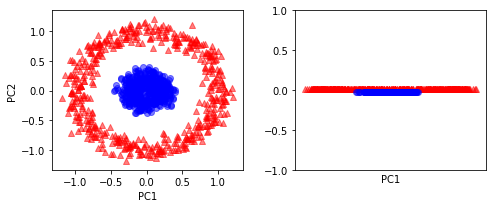

In [33]:
# データをPCAで変換してからプロット
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(7,3))
ax[0].scatter(X_spca[y==0,0],X_spca[y==0,1],
             color='red',marker='^',alpha=0.5)
ax[0].scatter(X_spca[y==1,0],X_spca[y==1,1],
             color='blue',marker='o',alpha=0.5)

ax[1].scatter(X_spca[y==0,0],np.zeros((500,1))+0.02,
             color='red',marker='^',alpha=0.5)
ax[1].scatter(X_spca[y==1,0],np.zeros((500,1))-0.02,
             color='blue',marker='o',alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_xticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

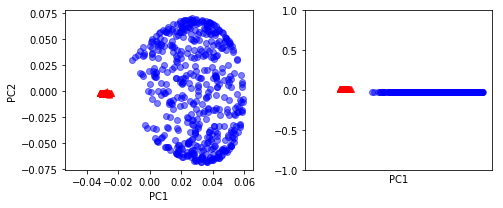

In [34]:
# データをRBFカーネルPCAで変換してからプロット
X_kpca = rbf_kernel_pca(X,gamma=15,n_components=2)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(7,3))
ax[0].scatter(X_kpca[y==0,0],X_kpca[y==0,1],
             color='red',marker='^',alpha=0.5)
ax[0].scatter(X_kpca[y==1,0],X_kpca[y==1,1],
             color='blue',marker='o',alpha=0.5)

ax[1].scatter(X_kpca[y==0,0],np.zeros((500,1))+0.02,
             color='red',marker='^',alpha=0.5)
ax[1].scatter(X_kpca[y==1,0],np.zeros((500,1))-0.02,
             color='blue',marker='o',alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_xticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

# 5.3 新しいデータ点を射影する
実際の応用では、トレーニングデータとテストデータのように変換したいデータセットが2つ以上存在する。
トレニンーグデータセットに含まれていなかったデータ点を射影する方法について説明する。

In [35]:
from scipy.spatial.distance import pdist,squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X,gamma,n_components):
    """
    RBFカーネルPCAの実装
    
    パラメータ
    ---------------------
    X: (Numpy ndarray),shape = [n_samples,n_features]
    
    gamma : float
        RBF カーネルのチューニングパラメータ
        
    n_components : int
        返される主成分の個数
    
    -----------------------
    
    
    戻り値
    ------------------------
    X_pca : (Numpy ndarray), shape = [n_samples,k_features]
        射影されたデータセット
        
    lambdas : list
        固有値
        
    """
    
    # M*N次元のデータセットでペアごとのユーグリッド距離の2乗を計算
    sq_dists = pdist(X,'sqeuclidean')
    
    # ペアごとの距離を正方行列に変換
    mat_sq_dists = squareform(sq_dists)
    # print(mat_sq_dists)
    
    # 対称カーネル行列を計算
    K = exp(-gamma * mat_sq_dists)
    
    # カーネル行列を中心化
    N = K.shape[0]
    one_n = np.ones((N,N))/N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # 中心化されたカーネル行列から固有対を取得：scipy.linalg.eighはそれらを昇順で表す
    eigvals,eigvecs = eigh(K)
    eigvals,eigvecs = eigvals[::-1],eigvecs[:,::-1]
    
    # 上位k個の固有ベクトル（射影されたサンプル）を収集
    alphas = np.column_stack((eigvecs[:,i]
                             for i in range(n_components)))
    
    # 対応する固有値を収集
    lambdas = [eigvals[i] for i in range(n_components)]
    
    return alphas,lambdas

In [36]:
X,y = make_moons(n_samples=100,random_state=123)
alphas,lambdas = rbf_kernel_pca(X,gamma=15,n_components=1)

In [37]:
x_new = X[25]
print(x_new)

x_proj = alphas[25]
print(x_proj)

def project_x(x_new,X,gamma,alphas,lambdas):
    pair_dist = np.array([np.sum((x_new-row)**2)for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

[1.8713 0.0093]
[0.0788]


In [38]:
x_reproj = project_x(x_new,X,gamma=15,alphas=alphas,lambdas=lambdas)
x_reproj

array([0.0788])

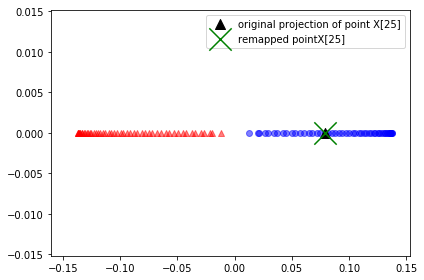

In [42]:
plt.scatter(alphas[y==0,0],np.zeros((50)),color='red',marker='^',alpha=0.5)
plt.scatter(alphas[y==1,0],np.zeros((50)),color='blue',marker='o',alpha=0.5)
plt.scatter(x_proj,0,color='black',label='original projection of point X[25]',
           marker='^',s=100)
plt.scatter(x_proj,0,color='green',label='remapped pointX[25]',marker='x',s=500)
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.show()

## 5.3 scikit-learnのカーネル主成分分析
カーネルPCAはscikit-learnのsklearn.decompositionモジュールに実装されている。本章のカーネルPCAの実装と同じ結果になるかどうかを確認できるよう、最初の2つの主成分に変換された半月形データをプロットしてみよう。

In [44]:
from sklearn.decomposition import KernelPCA
X,y = make_moons(n_samples=100,random_state=123)
scikit_kpca = KernelPCA(n_components=2,kernel='rbf',gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

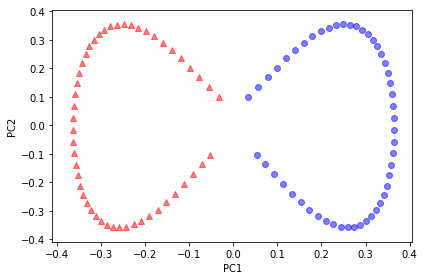

In [46]:
plt.scatter(X_skernpca[y==0,0],X_skernpca[y==0,1],color='red',marker='^',alpha=0.5)
plt.scatter(X_skernpca[y==1,0],X_skernpca[y==1,1],color='blue',marker='o',alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

scikit-learnのKernelPCAの結果は、本章の実装結果と一致する。